# COUNTLAND: python tutorial
### Samuel H. Church

This tutorial demonstrates the major functions of `countland` by applying them to a Gold standard single-cell RNA sequencing dataset from [Freytag _et al_ (2018)](10.12688/f1000research.15809.2).

`countland` is a **barebones** set of functions for applying a restricted linear algebra to the analysis of count-based data. As such, there are many opportunities for further optimization that may prove useful in the anlaysis of your own data. We provide the source code freely available at https://github.com/shchurch/countland and encourage users and developers to fork the code for their own purposes.

The following packages are required to complete the tutorial

In [1]:
import sys
import logging

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
plt.style.use('classic')
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map="viridis")

scanpy==1.8.2 anndata==0.7.8 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


## GET THE DATA

We have used the Gold standard dataset provided by [Freytag _et al_ (2018)](10.12688/f1000research.15809.2). This data consists of ~1000 cells that have ground truth labels corresponding to three human lung cell lines.

`countland` accepts an AnnData object (as does `scanpy`). 

In [2]:
adata = sc.read_10x_mtx(
    "../data/Gold_Freytag2018",  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/..-data-Gold_Freytag2018-matrix.h5ad


## IMPORT COUNTLAND
The source code for `countland` in `python` is located in `countland-py/countland.py`

In [3]:
import countland as countland

In [4]:
# for testing, this will reload countland functions (e.g. after an edit)

import importlib
importlib.reload(countland)

<module 'countland' from '/Users/samuelchurch/Downloads/countland/countland-py/countland.py'>

## INITIALIZE COUNTLAND OBJECT

Initialize `countland` by calling the core function on an AnnData object.

In [5]:
C = countland.countland(adata)
print(C)

initializing countland object...
removing empty cells and genes...

        countland object
        Count matrix has 925 cells (rows) 
         and 29212 genes (columns)
        The fraction of entries that are nonzero is 0.2905
        


The count matrix is stored in `C.counts`

In [6]:
C.counts

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  6,  1,  0],
       [ 0,  0,  0, ..., 12,  2,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  1,  0]])

Note that most counts are zero for scRNA-seq data.

## EVALUATE DATA QUALITY

We can establish data quality by checking the total number of counts and other expression measures per cell.

In addition, it can be helpful to see how many counts are derived from certain genes, such as mitochondrial genes (here we have chosen a gene name with particularly high counts, regular expressions are permitted for name matching).

Expression measures include:
- maximum number of counts observed across genes
- total counts
- number of genes with observed counts
- number of genes with counts above 1, or 10
- number of unique count values per cell
- count index = number of _n_ genes with _n_ counts

In [7]:
C.ScoreCells(gene_string="^ENSG00000140988$")
C.cell_scores

,names,max_count_value,total_counts,n_features,n_features_above1,n_features_above10,unique_count_values,count_index,feature_match_counts
0,H2228_AAACCTGCAGACACTT-1,2081,101014,8684,5911,1416,227,24,869
1,H1975_AAAGATGCACATTTCT-1,1010,100763,8574,5746,1432,227,25,919
2,H1975_AAAGATGTCCTTTACA-1,1803,121201,9190,6316,1567,245,24,1605
3,H2228_AAAGCAACATCAGTAC-1,2933,136800,9635,6798,1730,263,28,1335
4,H1975_AAATGCCCACTTCGAA-1,1097,95220,8433,5643,1390,219,24,1097
...,...,...,...,...,...,...,...,...,...
920,H1975_TTTGGTTAGATGCCAG-1,995,83795,8524,5533,1158,199,22,995
921,HCC827_TTTGGTTCAGTCAGCC-1,3442,163971,8934,6336,1837,279,28,1656
922,H2228_TTTGGTTTCCATTCTA-1,2847,140528,9307,6740,1921,257,29,1285
923,H2228_TTTGTCAAGATCCCAT-1,1149,74919,7817,4970,1078,193,25,602


## FILTER DATA

Standard workflows often filter data based on quality measures, such as the number of unique features per cell. 

In [8]:
filter_cells = np.array(C.cell_scores['n_features'] < 8500) # cells with fewer than 8,500 unique genes observed
C.SubsetCells(filter_cells,remove_empty=False)

Number of genes: 29212
Number of cells: 463


In [9]:
filter_genes = (np.sum(C.counts,0) > 0) # genes with observations
C.SubsetGenes(filter_genes,remove_empty=False) # genes with observations 

# note the same could be accomplished by running
#     C.SubsetCells(filter_cells,remove_empty=True)
# above

Number of genes: 26298
Number of cells: 463


With `countland`, such data filtering may not be necessary or helpful. The original count matrix can be restored at any time.

In [10]:
C.RestoreCounts()

Number of genes: 29212
Number of cells: 925


## SUBSAMPLE GENES

Cells are not sequenced to standard sequencing depth. This is sometimes a problem for downstream comparisons.  

You can create an alternative count matrix where cells have an equal number of counts using `C.Subsample()`. The number of counts must not be larger than the minimum number per cell.

This matrix is stored in `C.subsample`

In [23]:
np.random.seed(84095) # choose a random seed for reproducibility
C.Subsample(n_counts = 1000)

## COMPARE GENES BY COUNTS

Using the subsampled count matrix, we can make comparisons of gene expression using several count-based assessments. These include:
- maximum number of counts observed across cells
- total counts
- number of cells with observed counts
- number of cells with counts above 1, or 10
- number of unique count values
- count index = number of _n_ cells with _n_ counts

In [24]:
C.ScoreGenes(subsample=True)
C.gene_scores.sort_values(by="unique_count_values",ascending=False)

,names,max_count_value,total_counts,n_cells,n_cells_above1,n_cells_above10,unique_count_values,count_index
15781,ENSG00000251562,48,8642,899,850,315,42,16
15644,ENSG00000167996,58,7807,916,893,238,39,16
10901,ENSG00000132432,43,5128,692,468,222,33,18
27652,ENSG00000087086,43,5145,847,729,142,30,13
29170,ENSG00000210082,31,7270,921,909,202,25,15
...,...,...,...,...,...,...,...,...
13152,ENSG00000253570,0,0,0,0,0,0,0
13151,ENSG00000253361,0,0,0,0,0,0,0
13150,ENSG00000196166,0,0,0,0,0,0,0
13149,ENSG00000239218,0,0,0,0,0,0,0


We can also visualize counts across genes with a stripplot

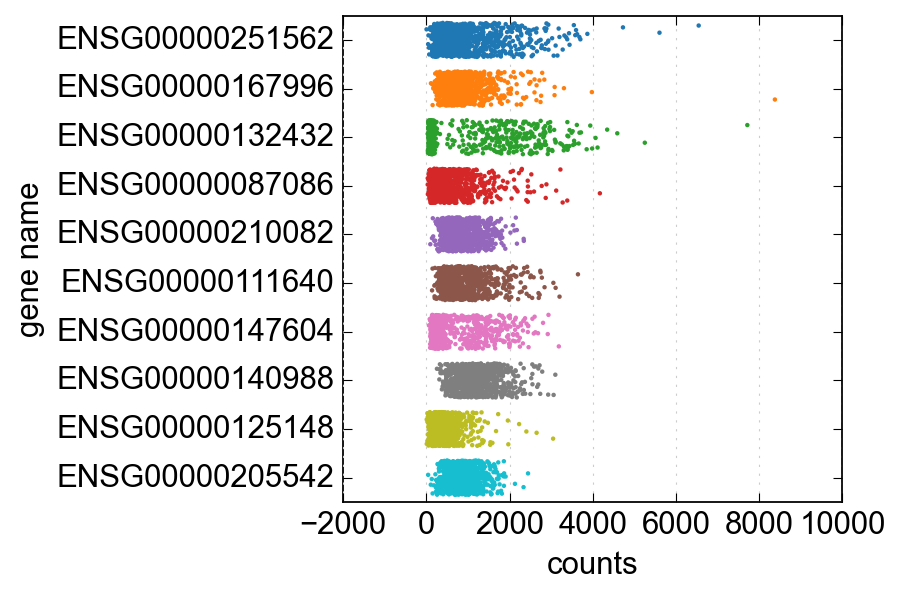

In [13]:
gene_indices = C.gene_scores.sort_values(by="unique_count_values",ascending=False).head(10).index

C.PlotGeneCounts(gene_indices)

## COMPARE CELLS AND CLUSTER

The dot (or inner) product is a measure of alignment between vectors. In this case, it tells us how similar two cells are based on the proportions of counts, and scaled by the total counts per cell. A dot product of 0 indicates orthogonal cell vectors (no shared counts), larger values indicate aligned cell vectors.

In [14]:
C.Dot()

Calculating dot products between rows...
    done.


Cell populations can be compared and distinguished by embedding and clustering the matrix of pairwise dot products (contained in `C.dots`). This matrix is an unbounded affinity matrix. It is symmetric, and contains only integer values above 0. Spectral embedding clustering is appropriate for this type of matrix.

First, we embed to investigate the optimal number of clusters for our data.

In [15]:
C.Embed()

performing spectral embedding on dot products...
    done.


The eigengap heuristic is can help decide the optimal number of clusters, but it is only a guideline. According to this heuristic, the optimal number of clusters is _k_ where the difference in eigenvalues $ | e_{k+1} - e_{k} | $ is largest.

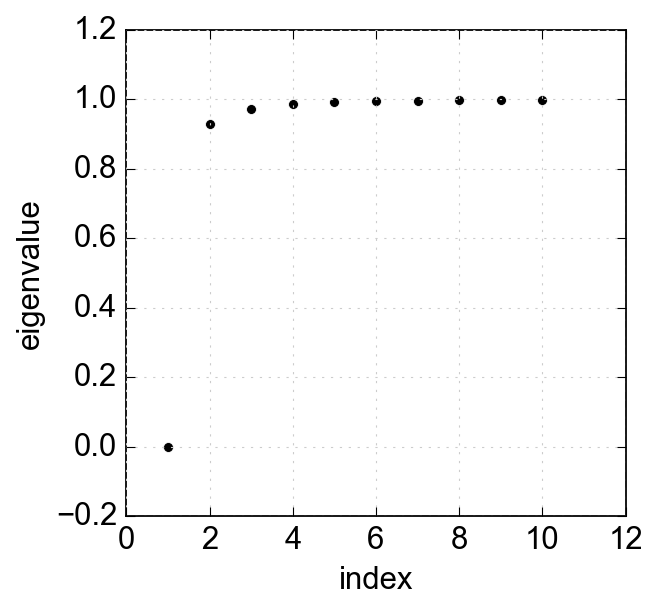

In [16]:
C.PlotEigengap()

For many datasets, you may want to consider other factors, e.g. choosing a minimum number of clusters, whether or not the eigengap reflects this.

Here we have chosen 3 as the optimal number of clusters.

In [17]:
C.Cluster(n_clusters=3)

performing spectral clustering on dot products...
    done.


### VISUALIZING WITH SPECTRAL EMBEDDING OF DOT PRODUCTS

We can now visualize clusters using spectral embedding.

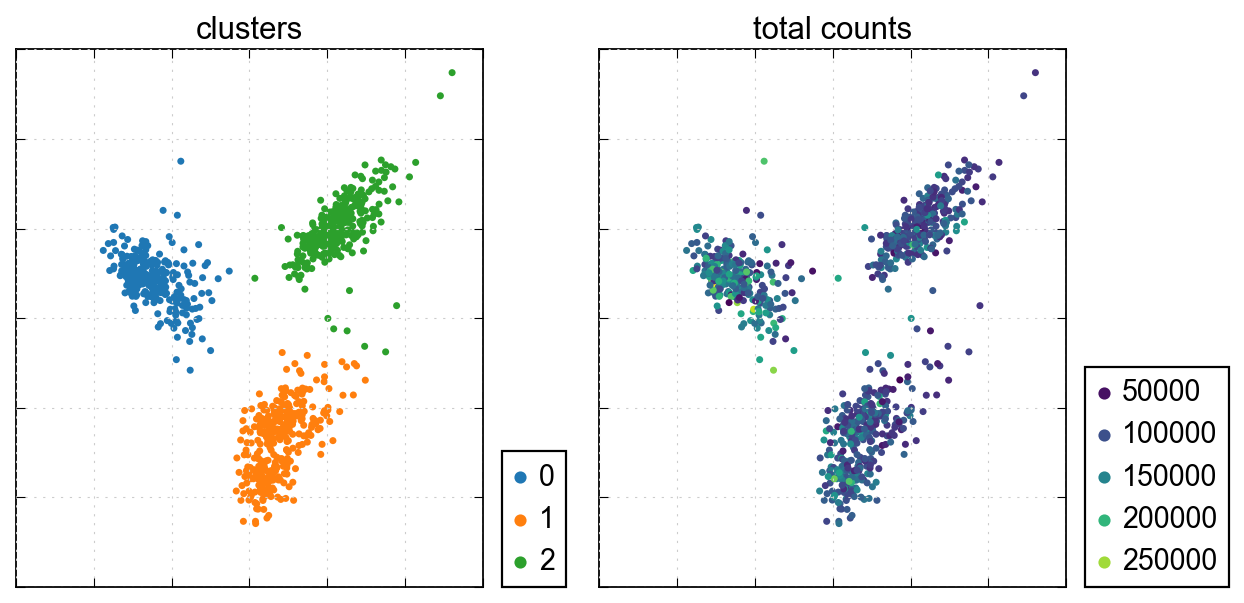

In [18]:
C.PlotEmbedding()

## IDENTIFY MARKER GENES

What makes a gene an ideal marker for a cluster may depend on downstream applications. For example, the ideal marker gene might be defined as the gene detected in all of the cells in a given cluster and none of the rest.

Under this definition, the top marker gene for each cluster can be identified by counting and comparing the number of non-zero cells.

In [19]:
C.RankMarkerGenes(method='prop-zero')
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

,diff. proportion zero,rank,gene index,gene names,cluster_label
29209,0.908334,1,29209,ENSG00000276345,1
20101,0.893986,2,20101,ENSG00000258949,1
10929,0.849809,3,10929,ENSG00000237268,1
27900,0.844985,4,27900,ENSG00000129991,1
26020,0.797944,5,26020,ENSG00000100979,1
3650,0.788872,6,3650,ENSG00000186281,1
10885,0.787818,7,10885,ENSG00000164744,1
24455,0.775748,8,24455,ENSG00000262902,1
28254,0.766979,9,28254,ENSG00000185686,1
20760,0.742432,10,20760,ENSG00000156414,1


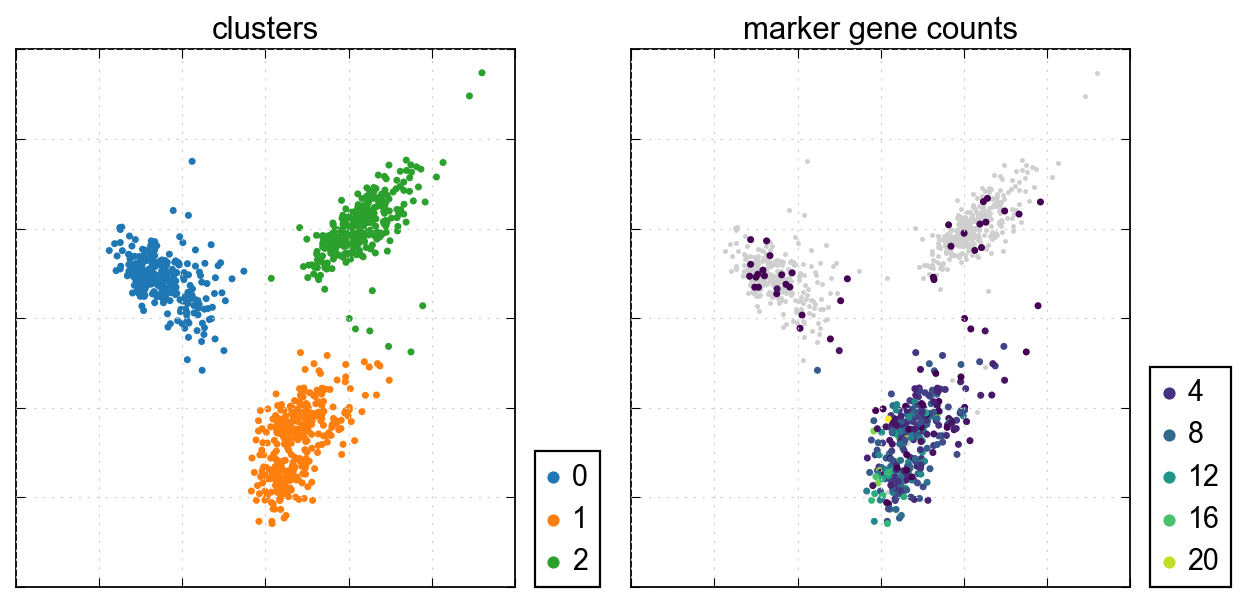

In [20]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values
C.PlotMarker(gene_index)

Alternatively, the top marker genes for each cluster can be identified by ranking genes using the Wilcoxon rank-sum statistic.

**Note this can take some time.**

In [21]:
C.RankMarkerGenes(method='rank-sums')
gdf = C.marker_genes.loc[(C.marker_genes['cluster_label'] == 1)]
gdf

,test-statistic,p-value,adjusted-p-value,significant diff.,rank,gene index,gene names,cluster_label
24455,192940.5,5.362578e-155,3.916291e-151,True,1,24455,ENSG00000262902,1
19921,192899.5,9.394985e-138,3.430579e-134,True,2,19921,ENSG00000100867,1
23460,192435.0,2.897973e-134,8.465559e-131,True,3,23460,ENSG00000170291,1
29209,191532.5,3.611255e-169,1.054920e-164,True,4,29209,ENSG00000276345,1
9866,191066.0,5.557984e-130,1.248922e-126,True,5,9866,ENSG00000203875,1
28423,191065.5,1.871308e-130,4.555388e-127,True,6,28423,ENSG00000198832,1
27900,190786.0,2.255125e-157,2.195890e-153,True,7,27900,ENSG00000129991,1
17439,190343.5,4.332233e-139,1.807903e-135,True,8,17439,ENSG00000065621,1
20101,188484.0,9.738780e-164,1.422446e-159,True,9,20101,ENSG00000258949,1
26020,187175.5,2.480787e-143,1.207813e-139,True,10,26020,ENSG00000100979,1


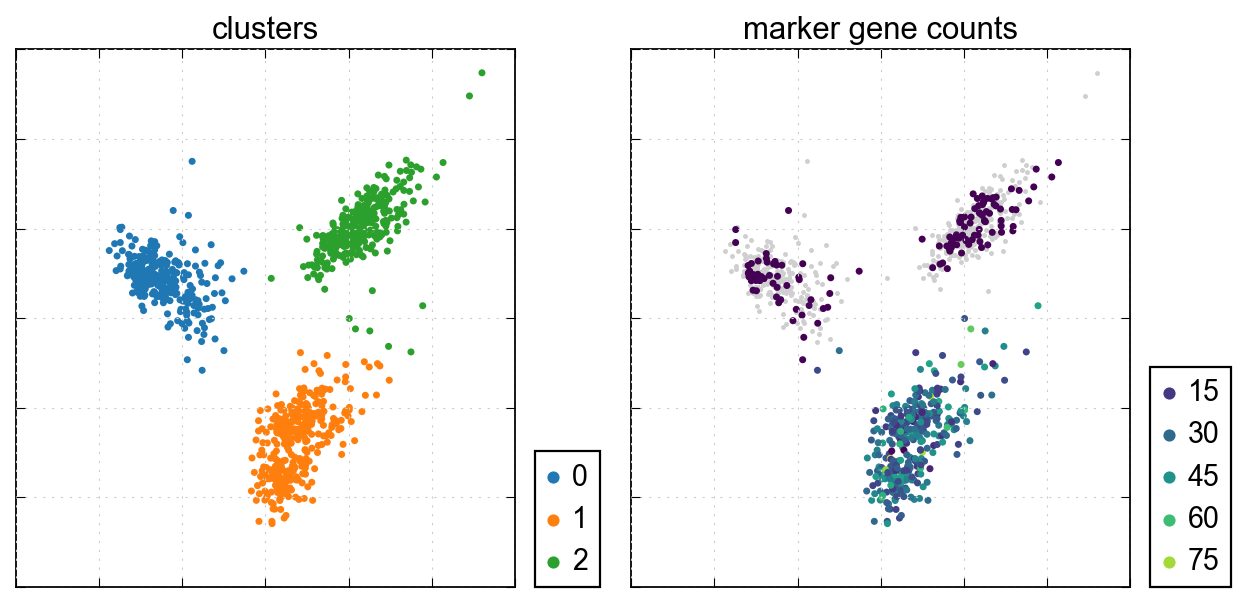

In [22]:
gene_index = gdf.loc[(gdf['cluster_label'] == 1) & (gdf['rank'] == 1)]['gene index'].values 
C.PlotMarker(gene_index)

## RECAPITULATING STANDARD APPROACHES

`countland` also includes functions for recapitulating the standard transformation steps for scRNA-seq data.

**Note that these are not recommended**

In [23]:
C._Normalize()
C._Log()
C._RescaleVariance()
C._Center()

Normalizing counts...
    done.
Log transforming normalized counts...
    done.
Scaling transformed counts to gene unit variance...
    done.
Centering counts...
    done.
